In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
start_line = 6

data = pd.read_csv('Thesis_Samples_Data/Flexural_Solid_2/Flexural_Solid_2.csv', skiprows=start_line)
data = data.drop([0])
data

,Crosshead,Load,Time
1,0,1.452944875,0.02
2,4.88E-05,1.545757055,0.039999999
3,4.88E-05,1.537567496,0.059999999
4,4.88E-05,1.520975828,0.079999998
5,4.88E-05,1.463552713,0.100000001
...,...,...,...
3315,0.132568355,40.33127213,66.30000305
3316,0.132617191,40.38057709,66.31999969
3317,0.132666013,40.46768188,66.33999634
3318,0.132666013,40.07409668,66.36000061


39.03699493


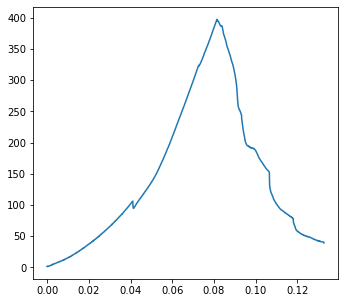

In [4]:
# get relevant columns and preprocess
crosshead = data.loc[:, 'Crosshead '].to_numpy(dtype=np.double)
load = data.loc[:, 'Load '].to_numpy(dtype=np.double)

crosshead = abs(crosshead)
load = abs(load)

stop_index = 9919 - start_line
load = load[0:stop_index]

print(load[-1])

plt.figure(figsize=(12, 5))

sub = plt.subplot(1, 2, 1)
sub.plot(crosshead, load)


## Define Sample Parameters

In [5]:
S = 90      # span, mm
B = 39.97      # width, mm
W = 26.37# thickness, mm
E = 25000    # young's modulous, MPa
cement_percent = 1

## MOR Calculation

![title](img/MOR.png)

[from C78]

In [6]:
# find max load and associated index first
P_max = np.max(load)
pl_index = np.argmax(load)

MOR = P_max*S/(B*W**2)
MOR_normalized = MOR / cement_percent
MOR

1.2866440730202213

## Overall Toughness

Overall toughness is the area under the load-displacement curve, with the slope leading up to the first peack linearlized.

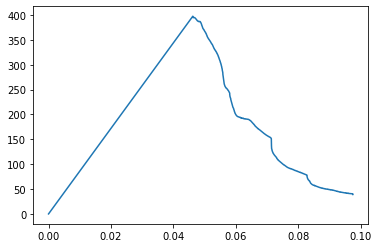

In [7]:
# Find pre-peak slope
num_reg_points = int(pl_index / 5)
crosshead_reg = crosshead[pl_index-num_reg_points:pl_index]
load_reg = load[pl_index-num_reg_points:pl_index]
A = np.vstack([crosshead_reg, np.ones(len(crosshead_reg))]).T
m, c = np.linalg.lstsq(A, load_reg, rcond=None)[0]

# crop data into post-peak region
crosshead_pl = crosshead[pl_index:]
load_pl = load[pl_index:]

crosshead_P_max = crosshead[pl_index]

# generate new data values where lead-up to peak is linearized
x_int = crosshead_P_max - (P_max/m)

crosshead_P_max = crosshead[pl_index]
crosshead_el = np.linspace(0, crosshead_P_max-x_int, num=pl_index)
load_el = m * np.copy(crosshead_el)

# plt.plot(crosshead_el, load_el)

crosshead_linearized = np.concatenate((crosshead_el, crosshead_pl-x_int))
load_linearized = np.concatenate((load_el, load_pl))
plt.plot(crosshead_linearized, load_linearized)

In [8]:
# now integrate under linearized load-displacement curve
toughness_overall = np.trapz(load_linearized, x=crosshead_linearized)
toughness_overall_normalized = toughness_overall / cement_percent
toughness_overall

17.414980453262658

## Stress-Based Toughness

Find toughness by finding the area under the displacement-stress curve, where stress is defined as

![title](img/stress.png)

![title](img/stress_constants.png)


[from Wikepedia]

0.0845867525727419


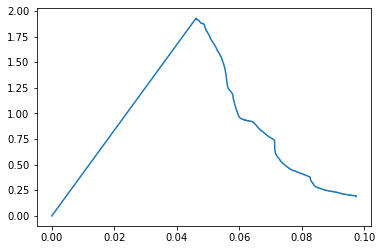

In [9]:
stress_linearized = 3*load_linearized*S/(2*B*W**2)

toughness_stress = np.trapz(stress_linearized, x=crosshead_linearized)
toughness_stress_normalized = toughness_stress / cement_percent

print(toughness_stress)

plt.plot(crosshead_linearized, stress_linearized)